# Library

In [1]:
%matplotlib inline
import numpy as np
import cv2
import skimage.data as data
import matplotlib.pyplot as plt
import pydicom
import os

# Function

In [2]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(9, 9))
  if ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()
def masking(image):
    foreground_value = 255
    mask = np.uint8(image >= foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    image = np.zeros_like(image)
    image[labels == largest_label] = foreground_value
    ShowImage('image',image,'rgb')

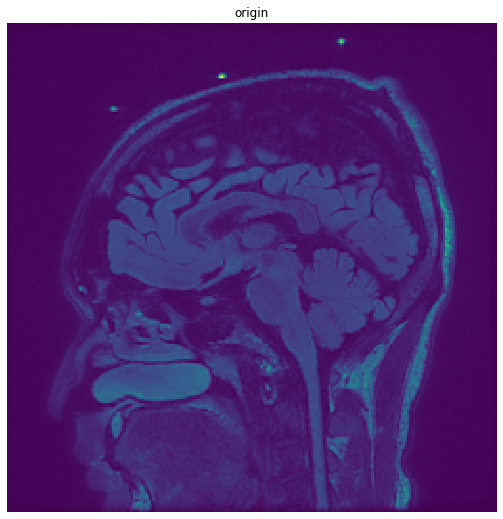

In [3]:
basepath ="../dicom/"
d = pydicom.read_file(basepath + "Z108")
file = np.array(d.pixel_array)
img = file
ShowImage('origin',img,'rgb')

In [4]:
img_2d = img.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

# Otsu Thresholding

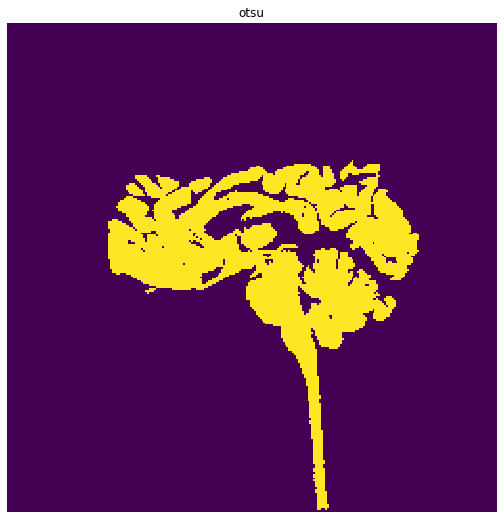

In [5]:
#OTSU THRESHOLDING
_,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
foreground_value = 255
mask_binarized = np.uint8(binarized == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask_binarized, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
otsu = np.zeros_like(binarized)
otsu[labels == largest_label] = foreground_value
ShowImage('otsu',otsu,'rgb')

# opening from thresholding

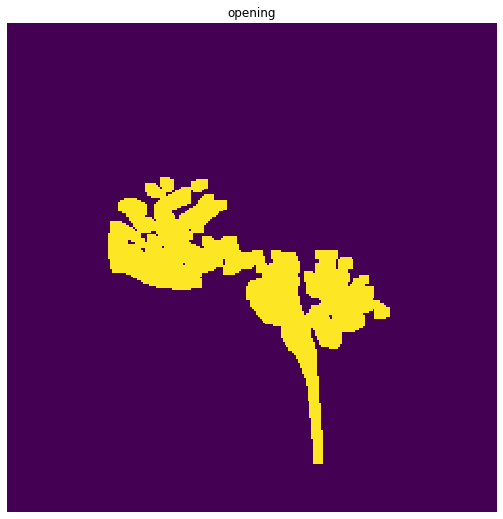

In [6]:
bentuk = np.ones((5, 5), np.uint8)
opening = cv2.morphologyEx(otsu, cv2.MORPH_OPEN, bentuk)
# ShowImage('opening',opening,'rgb')

foreground_value = 255
mask_opening = np.uint8(opening >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_opening, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
buka = np.zeros_like(opening)
buka[labels == largest_label] = foreground_value
ShowImage('opening',buka,'rgb')

# erosion from opening

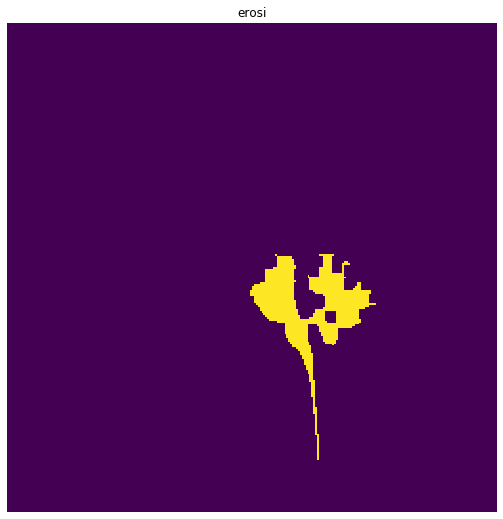

In [7]:
kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(buka,kernel,iterations = 1)

foreground_value = 255
mask_erosion = np.uint8(erosion >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_erosion, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
erosi = np.zeros_like(erosion)
erosi[labels == largest_label] = foreground_value
ShowImage('erosi',erosi,'rgb')

# Dilation 

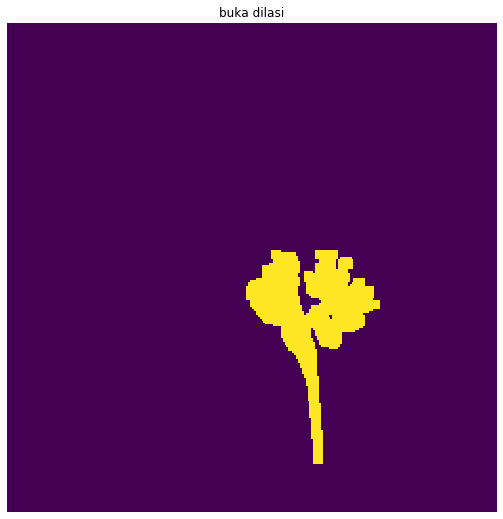

In [8]:
shape = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(erosi,shape,iterations = 1)

foreground_value = 255
mask_dilation = np.uint8(dilation >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_dilation, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
buka_dilasi = np.zeros_like(dilation)
buka_dilasi[labels == largest_label] = foreground_value
ShowImage('buka dilasi',buka_dilasi,'rgb')

# Skull Stripping

In [9]:
img_2d = file.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

#Skull Stripping
skull_stripped_image = cv2.bitwise_and(
    hasil, hasil, mask = buka_dilasi)
brain_pixels = skull_stripped_image[buka_dilasi == foreground_value]
print (brain_pixels, 'Brain Pixels')

# Adapting the data to K-means
kmeans_input = np.float32(brain_pixels.reshape(
    brain_pixels.shape[0], brain_pixels.ndim))
print(kmeans_input, 'Kmeans Input')

# K-means parameters
epsilon = 0.01
number_of_iterations = 50
number_of_clusters = 4
number_of_repetition = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            number_of_iterations, epsilon)
flags = cv2.KMEANS_RANDOM_CENTERS
print(criteria, 'criteria Paramaters')

# K-means segmentation
_, labels, centers = cv2.kmeans(
    kmeans_input, number_of_clusters, None, criteria,
    number_of_repetition, flags)
print(labels.shape, 'K-means segmentation')

# Adapting the labels
labels = labels.flatten('F')
for x in range(number_of_clusters):
    labels[labels == x] = centers[x]

[41 38 33 ... 55 52 48] Brain Pixels
[[41.]
 [38.]
 [33.]
 ...
 [55.]
 [52.]
 [48.]] Kmeans Input
(3, 50, 0.01) criteria Paramaters
(2708, 1) K-means segmentation


# Segmented Image

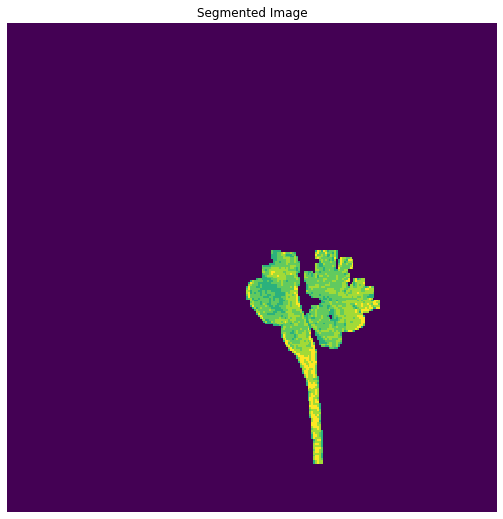

In [10]:
segmented_image = np.zeros_like(buka_dilasi)
segmented_image[buka_dilasi == foreground_value] = labels
ShowImage('Segmented Image',segmented_image,'rgb')

# All in One Row

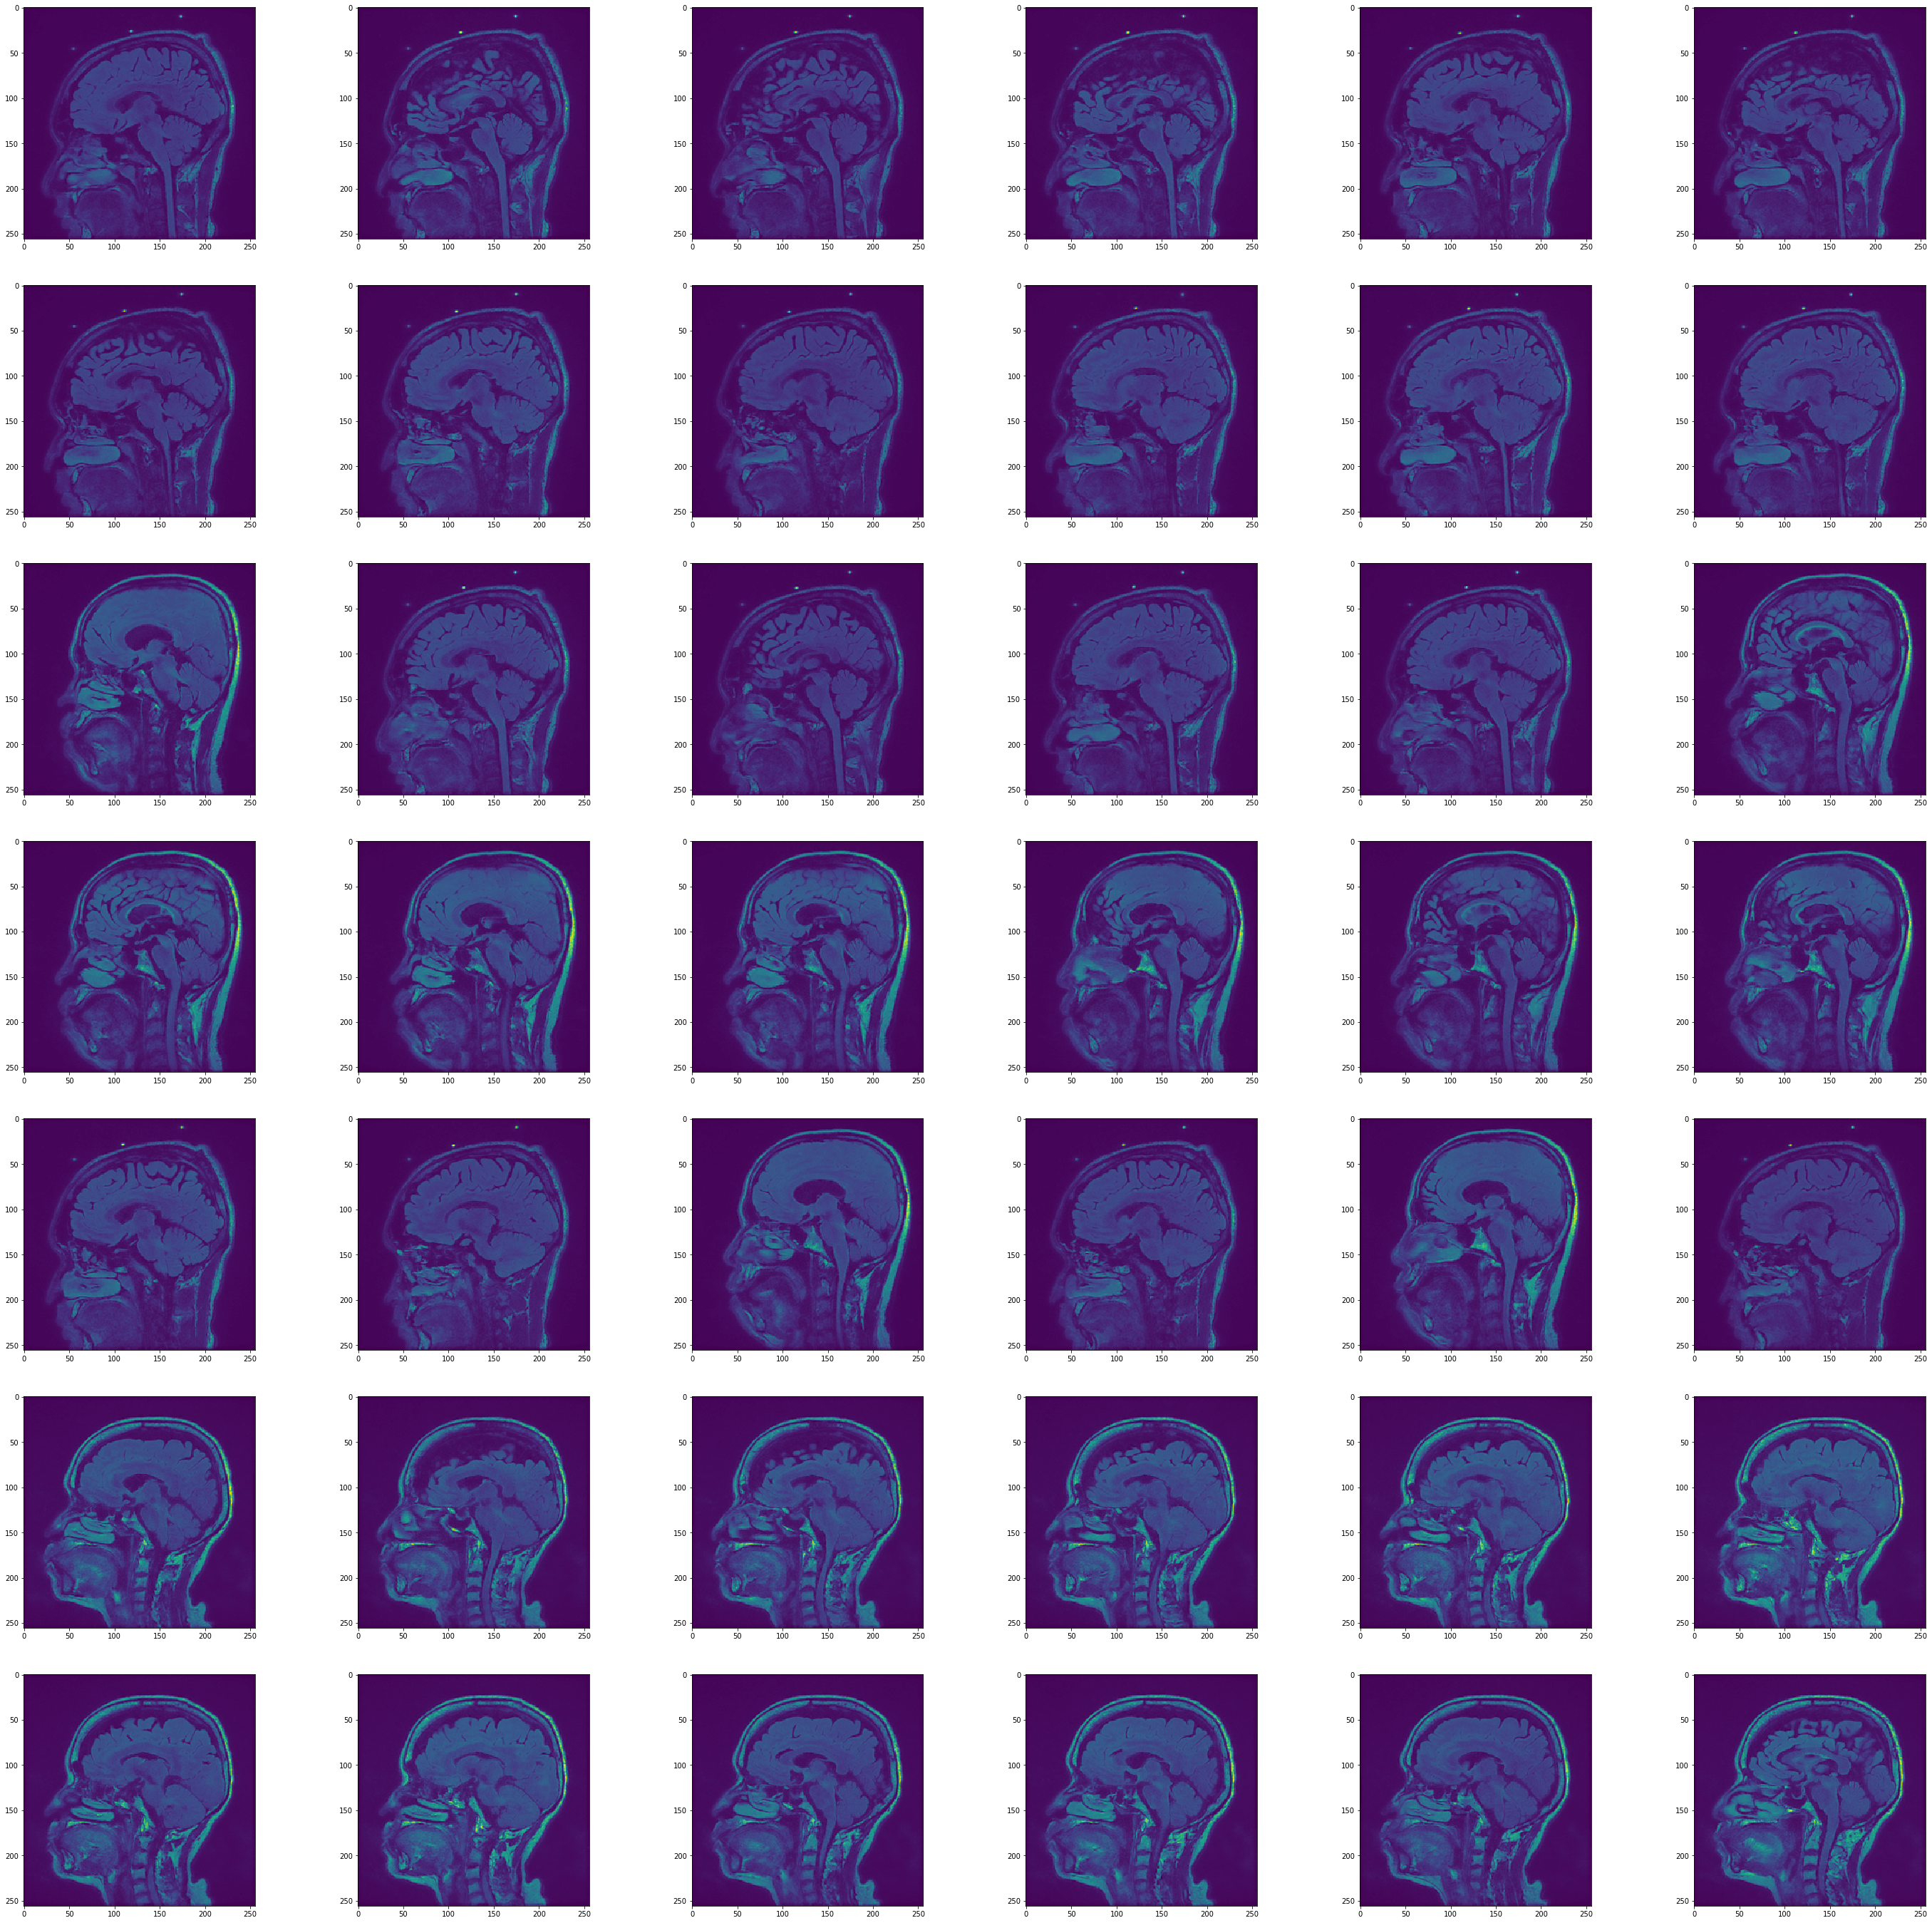

In [8]:
basepath ="../dicom/"
IMAGE_PATHS = os.listdir("../dicom/")
list_a = []

for f in IMAGE_PATHS:
    d = pydicom.read_file(basepath+f)
    a = np.array(d.pixel_array)
    
    img_2d = a.astype(float)
    img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
    img_2d_scaled = np.uint8(img_2d_scaled)
    hasil = img_2d_scaled
    list_a.append(hasil)
    
fig=plt.figure(figsize=(49, 49))
columns = 6
rows = 7
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(list_a[i])
plt.show()

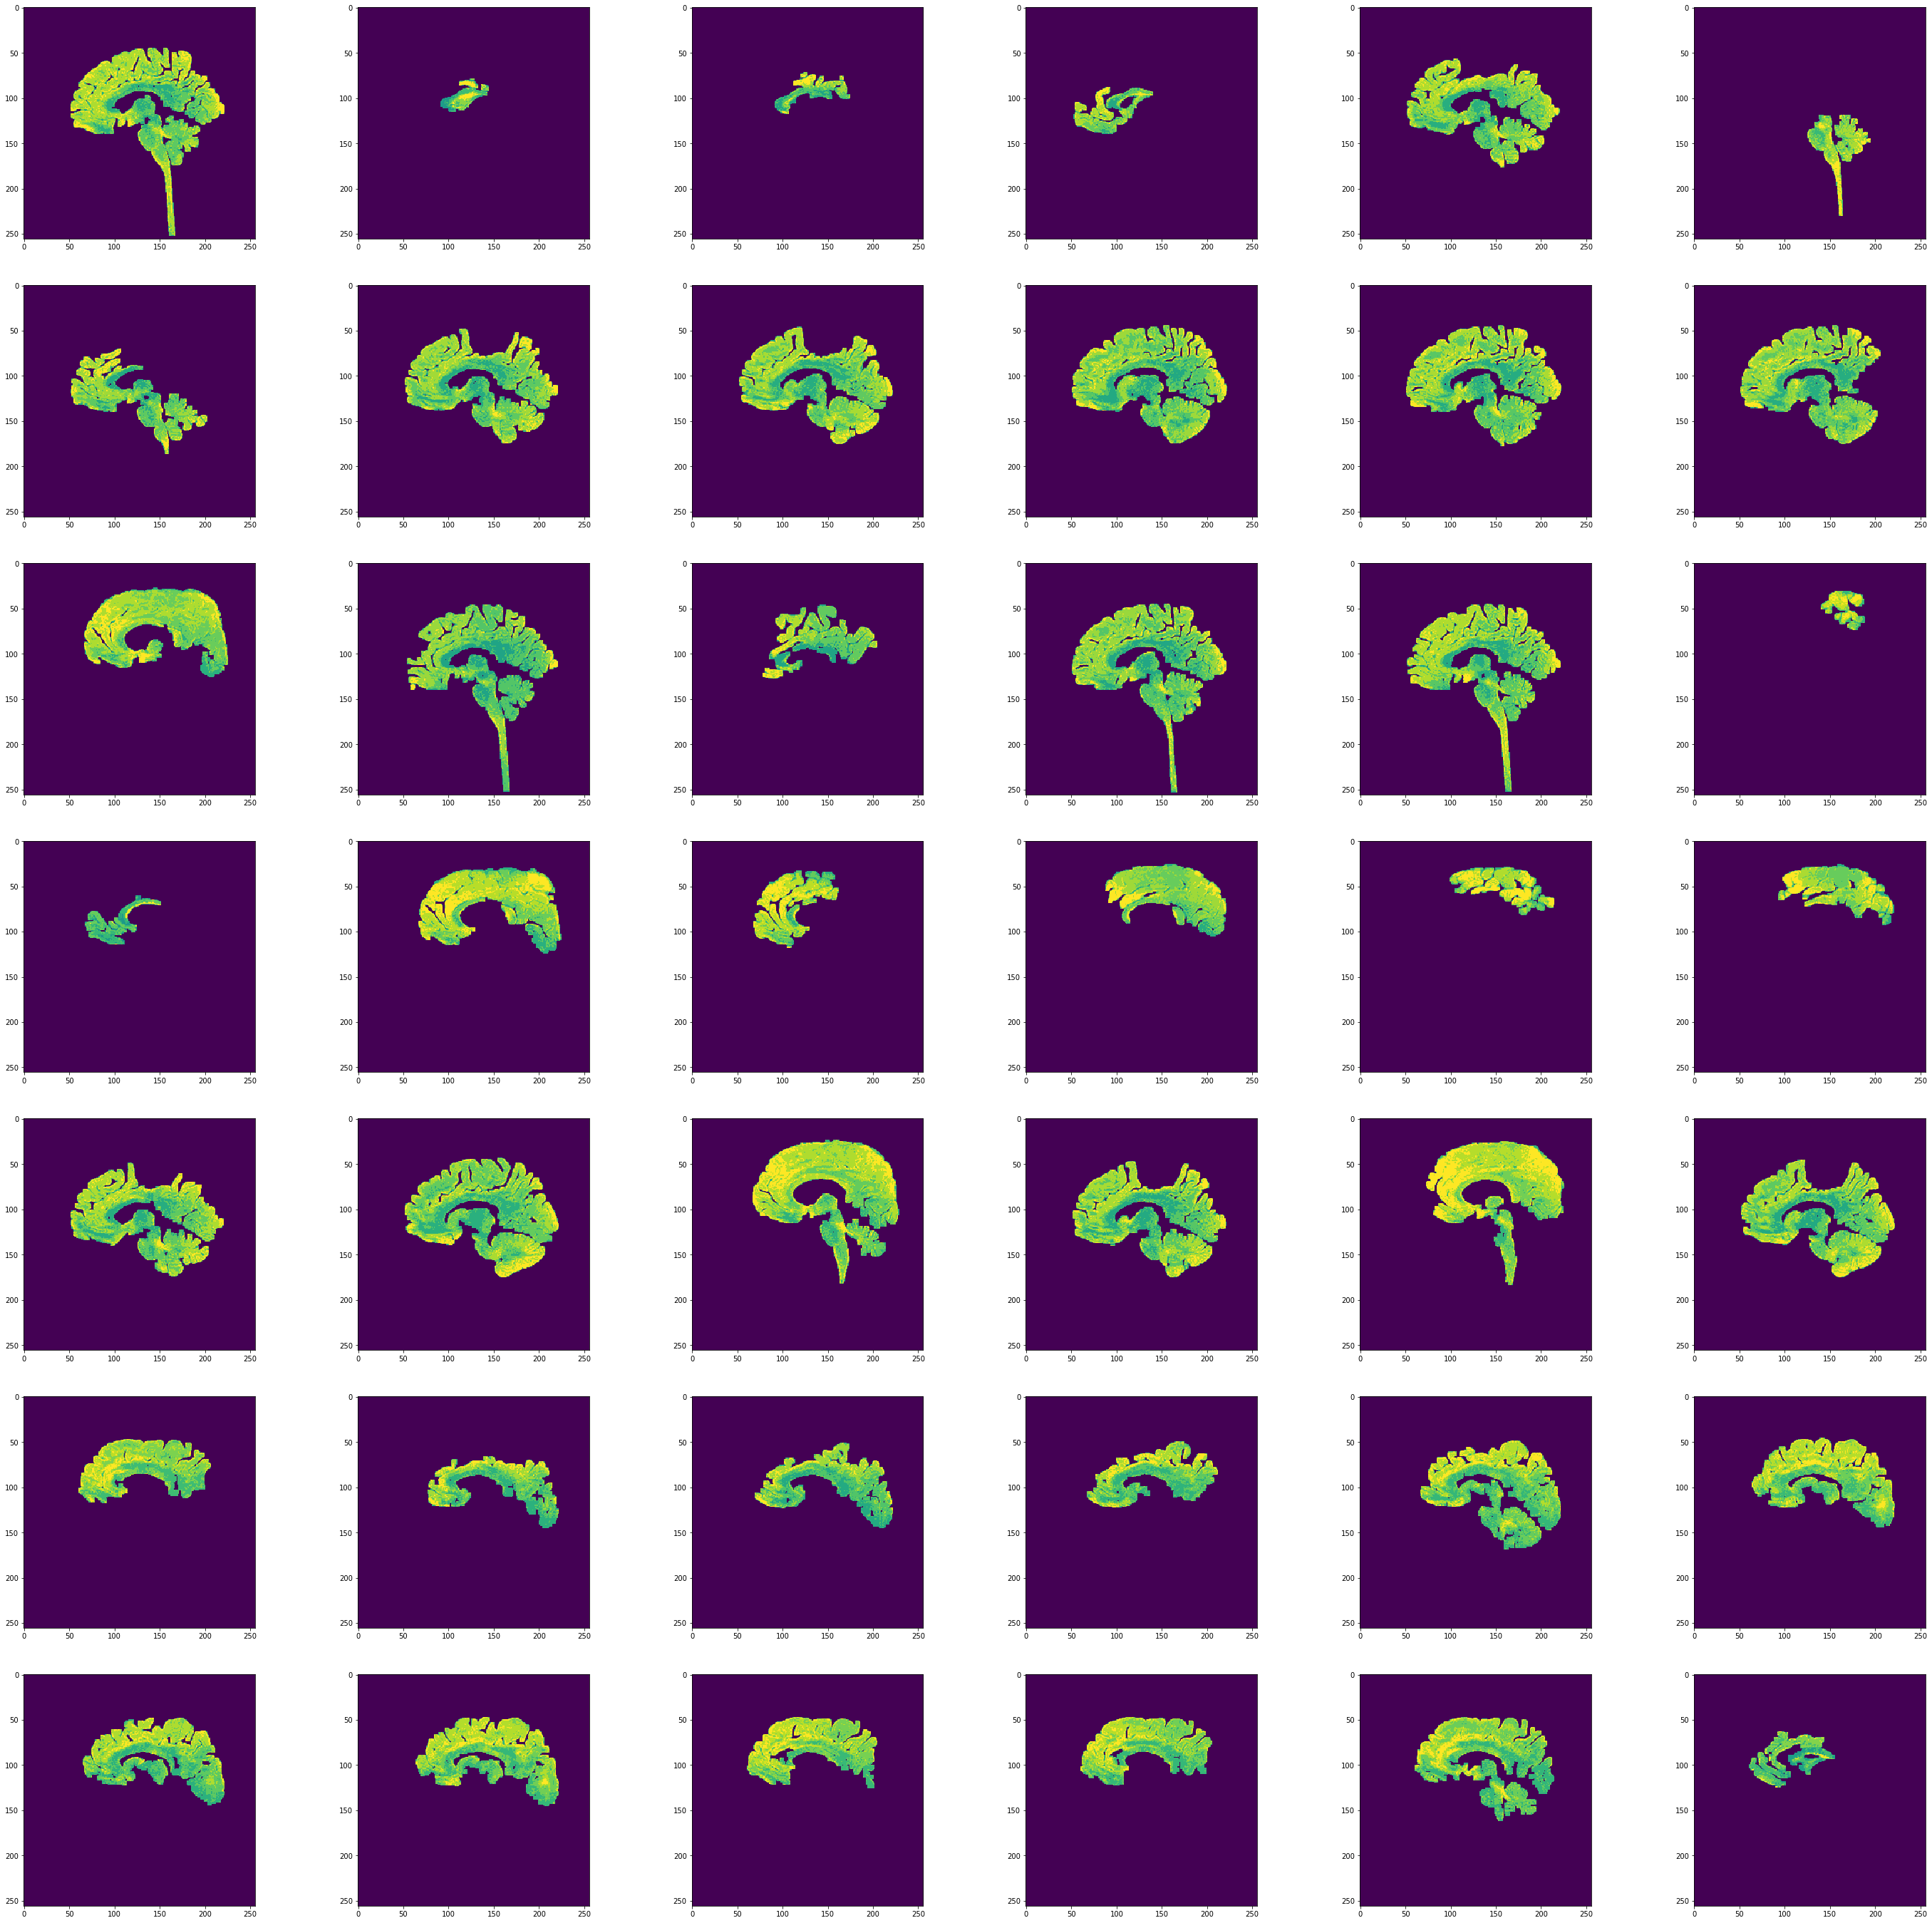

In [16]:
basepath ="../dicom/"
IMAGE_PATHS = os.listdir("../dicom/")
list_a = []

for f in IMAGE_PATHS:
    d = pydicom.read_file(basepath+f)
    a = np.array(d.pixel_array)
    
    img_2d = a.astype(float)
    img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
    img_2d_scaled = np.uint8(img_2d_scaled)
    hasil = img_2d_scaled
    
    #OTSU THRESHOLDING
    _,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    foreground_value = 255
    mask_binarized = np.uint8(binarized == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_binarized, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    otsu = np.zeros_like(binarized)
    otsu[labels == largest_label] = foreground_value
    
    bentuk = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(otsu, cv2.MORPH_OPEN, bentuk)

    foreground_value = 255
    mask_opening = np.uint8(opening >= foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_opening, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    buka = np.zeros_like(opening)
    buka[labels == largest_label] = foreground_value
    
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(buka,kernel,iterations = 1)

    foreground_value = 255
    mask_erosion = np.uint8(erosion >= foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_erosion, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    erosi = np.zeros_like(erosion)
    erosi[labels == largest_label] = foreground_value
    
    shape = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(erosi,shape,iterations = 1)

    foreground_value = 255
    mask_dilation = np.uint8(dilation >= foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_dilation, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    buka_dilasi = np.zeros_like(dilation)
    buka_dilasi[labels == largest_label] = foreground_value
    

    #Skull Stripping
    skull_stripped_image = cv2.bitwise_and(hasil, hasil, mask = buka_dilasi)
    brain_pixels = skull_stripped_image[buka_dilasi == foreground_value]

    # Adapting the data to K-means
    kmeans_input = np.float32(brain_pixels.reshape(brain_pixels.shape[0], brain_pixels.ndim))

    # K-means parameters
    epsilon = 0.01
    number_of_iterations = 50
    number_of_clusters = 4
    number_of_repetition = 10
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,number_of_iterations, epsilon)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # K-means segmentation
    _, labels, centers = cv2.kmeans(kmeans_input, number_of_clusters, None, criteria,number_of_repetition, flags)

    # Adapting the labels
    labels = labels.flatten('F')
    for x in range(number_of_clusters):
        labels[labels == x] = centers[x]
        
    segmented_image = np.zeros_like(buka_dilasi)
    segmented_image[buka_dilasi == foreground_value] = labels

    list_a.append(segmented_image)
    
fig=plt.figure(figsize=(49, 49))
columns = 6
rows = 7
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(list_a[i])
plt.show()